# Quantum Circuit for Modular Exponentiation using Qiskit

$\newcommand{\ket}[1]{|#1\rangle}$

Group 4:
- Writtika Sarkar, MCS202316
- Soham Chatterjee, BMC202175
- Shree Ganesh SJ, MCS202219

 This is based on the paper ["Quantum Networks for Elementary Arithmetic Operations"](https://arxiv.org/pdf/quant-ph/9511018.pdf) by Vlatko Vedral, Adriano Barenco and Artur Ekert in this circuit. 

>We assume that $gcd(a,N)=1$ which is not mentioned in the paper. However, this is infact necessary to preserve the unitarity of certain operations that we perform.


In [1]:
# Importing standard Qiskit libraries
from qiskit import QuantumCircuit, QuantumRegister, ClassicalRegister, AncillaRegister, transpile, Aer
from qiskit.tools.jupyter import *
from qiskit.visualization import *
import matplotlib as mpl
from qiskit.circuit.library import SwapGate
from math import *

from qiskit_aer import AerSimulator

from qiskit_ibm_runtime import QiskitRuntimeService, Sampler, Estimator, Session, Options

# Loading your IBM Quantum account(s)
service = QiskitRuntimeService(channel="ibm_quantum", token="c463eb3a1524dd933346849aed0b3d884b3ddc61eb9b51bb3d5e72fc187dc2000f09df38138222cde9284c2aea7a3b3a3d2694a96ef869e88ceccb898dd0b747")

ModuleNotFoundError: No module named 'qiskit_ibm_runtime'

## Plain Adder Circuit
This circuit is used to carry out addition of two states $\ket{a}$ and $\ket{b}$ using the following unitary gate $$\ket{a,b}\to \ket{a,a+b}$$.

The reverse of this gate on input $\ket{a}\ket{b}$ computes $\ket{a}\ket{a-b}$ if $a\geq b$ and $\ket{a}\ket{2^{n+1}-(b-a)}$ otherwise

### Carry Gate
The carry bit, $c_i$, corresponding to the sum of $i$th bits can be calculated with the help of carry generated by $i-1$th sum and $a_i$, $b_i$ which is $$c_i=(c_{i-1}\wedge a_{i-1})\vee (a_{i-1}\wedge b_{i-1})\vee (b_{i-1}\wedge c_{i-1})$$

We have implemented a gate below that does the same.

/usr/local/lib/python3.10/dist-packages/qiskit/visualization/circuit/matplotlib.py:266: FutureWarning: The default matplotlib drawer scheme will be changed to "iqp" in a following release. To silence this warning, specify the current default explicitly as style="clifford", or the new default as style="iqp".
  self._style, def_font_ratio = load_style(self._style)


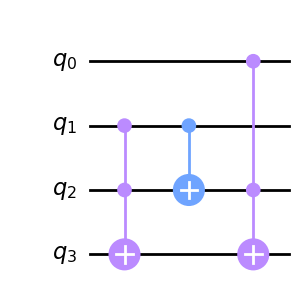

In [ ]:
#creating the 4-qubit carry circuit and reverse circuit for carrying operations for the adder

carry_circuit = QuantumCircuit(4, name = "CARRY")
carry_circuit.ccx(1,2,3)
carry_circuit.cx(1,2)
carry_circuit.ccx(0,2,3)
carry_gate = carry_circuit.to_gate()

reverse_carry_circuit = carry_circuit.inverse()
reverse_carry_gate = reverse_carry_circuit.to_gate()

carry_circuit.draw("mpl")
#reverse_carry_circuit.draw("mpl")

### Sum Gate
This calculates the sum of bits corresponding bits along with the carry. That can be calculated by again the carry generated by the previous bit pair and $a_i, b_i$ which is $$s_i=c_{i}\oplus a_i\oplus b_i$$

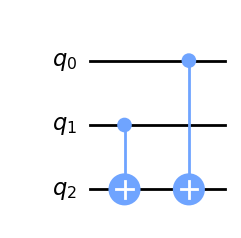

In [ ]:
#creating the 3-qubit sum circuit for summing the bits and storing bitwise outputs for adder

sum_circuit = QuantumCircuit(3, name = "SUM")
sum_circuit.cx(1,2)
sum_circuit.cx(0,2)
sum_gate = sum_circuit.to_gate()

sum_circuit.draw("mpl")

### Helper function

Below, we have defined several helper function to carry out necessary operations that are repeatedly occuring.

In [ ]:
#encoding values in n bits, by padding, if required, extra 0s in the beginning
def padding(string, n):
    l = n - len(string)
    if l != 0:
        pad = ['0' for i in range(l)]
        return ''.join(pad) + string
    return string


#converting an integer to a binary string
def bin_string(val):
    string = str(bin(val))
    return string[2:]


#creating the list of qubits of a quantum register
def make_list(qreg):
    m = qreg.size
    L = [qreg[i] for i in range(m)]
    return L


#computing a*2^i mod N for given a,i,N
def mult_comp(a, i, N):
    string = str(bin((a*(2**i)) % N))
    return string[2:]


#fast computation of a^(2^i) mod N by repeated squaring
def fast_exp(a,i,N):
    val = a
    for j in range(i):
        val = (val**2) % N
    return val
    

#converting a^(2^i) mod N to a binary string    
def exp_comp(a, i, N):
    string = str(bin(fast_exp(a, i, N)))
    return string[2:]


#loading a an integer encoded in binary to a quantumm register initialised to 0
def load(int_val, qreg, qct):
    m = qreg.size
    string = padding(bin_string(int_val), m)
    for i in range(m):
        if string[i]=='1':
            qct.x(qreg[m-i-1])
            

#computing the inverse of a^(2^i) mod N
def inv_mod_exp(a,i,N):
    m = fast_exp(a,i,N)
    for j in range(N):
        if (j*m)%N == 1:
            return j
    return 0

## Adder Modulo $N$
 This gate adds two states $\ket{a}$ and $\ket{b}$ modulo $N$. More precisely, this implements the unitary operation, $$\ket{a}\ket{b}\to \ket{a}\ket{a+b\bmod{n}}$$
 
 We implement this in multiple steps as follows:
- Calculate $a+b$
- Then subtract $N$ from $a+b$ using the reverse of plain adder
- Check the most significant  bit of the $a+b-N$:-
    - If 0: Then there is no subtraction overflow and so we dont do anything.
    - If 1: Then we add $N$ back to the value $a+b-N$ to get $a+b$.

For convenience, we instead do this operation using an adder gate controlled on this most significant bit flipped.

## Controlled Modulo Multiplication
Given a state $\ket{x}$, this gate outputs the state $\ket{x}\ket{ax \bmod{N}}$. We control this operation on another qubit to perform the following,
$$\ket{c}\ket{x}\ket{0}=\begin{cases} \ket{c}\ket{x}\ket{a\times x\bmod{N}}& \text{when $c=1$}\\ \ket{c}\ket{x}\ket{x} & \text{when $c=0$} \end{cases}$$
Since $ax=\sum\limits_{i=0}^{n-1}2^ix_ia$, we can compute modulo multiplication the following way, iterating on $i$ from $0$ to $n$:-
- If $x_i=0$, go to the next bit of $x_i$
- If $x_i=1$ set the value state $\ket{2^ia}$ to a register
- We get the state $\ket{2^ia}$ by calculating the value of $2^ia\bmod{N}$ classically.
- Then use modular adder gate to add the value of $2^ia$ to the previously computed value controlled on both the qubits $c$ and $x_i$.

## Modular Exponentiation
Here we will use the controlled modular multiplication to compute the value $a^x\bmod{N}$. 
$$a^x=a^{\sum\limits_{i=0}^{n-1}2^ix_i}=\prod\limits_{i=0}^{n-1}a^{2^ix_i}$$

Observe that,
$$\ket{a^{\sum\limits_{i=0}^{k-1}2^ix_i}}\ket{0}\to \ket{a^{\sum\limits_{i=0}^{k-1}2^ix_i}}\ket{0}\ket{a^{\sum\limits_{i=0}^{k}2^ix_i}}\ket{0}$$

Using this observation, we can do the following, we can compute the modular exponents by using repeated multiplication by $a^{2^{i}x_i}$ modulo $N$ to get $a^x (mod N)$ 

In [ ]:
def mod_exp(a, x, N):
    
    n = ceil(log2(N))
    
    qr_a = QuantumRegister(n, name='a')
    qr_b = QuantumRegister(n+1, name='b')
    qr_c = QuantumRegister(n, name='c')
    qr_N = QuantumRegister(n, name = "N")
    qr_t = QuantumRegister(1, name = "t")
    qr_1 = QuantumRegister(n, name='x')
    c = QuantumRegister(1, name='control')
    qr_x = QuantumRegister(2*n, name = "exponent")
    cr = ClassicalRegister(n, name = "output")
    
    #####################################################################################
    
    adder_circuit = QuantumCircuit(qr_a, qr_b, qr_c, name = "ADDER")

    for i in range(1,n):
        adder_circuit.append(carry_gate, [qr_c[i-1], qr_a[i-1], qr_b[i-1], qr_c[i]])

    adder_circuit.append(carry_gate, [qr_c[n-1], qr_a[n-1], qr_b[n-1], qr_b[n]])

    adder_circuit.cx(qr_a[n-1], qr_b[n-1])

    for i in range(n-1, 0, -1):
        adder_circuit.append(sum_gate, [qr_c[i], qr_a[i], qr_b[i]])
        adder_circuit.append(reverse_carry_gate, [qr_c[i-1], qr_a[i-1], qr_b[i-1], qr_c[i]])

    adder_circuit.append(sum_gate, [qr_c[0], qr_a[0], qr_b[0]])

    reverse_adder_circuit = adder_circuit.inverse()

    adder_gate = adder_circuit.to_gate()

    reverse_adder_gate = reverse_adder_circuit.to_gate()
    
    #####################################################################################
    
    adder_mod_circuit = QuantumCircuit(qr_a, qr_b, qr_c, qr_N, qr_t, name = "ADDER MOD")

    list_t = make_list(qr_t)
    list_a = make_list(qr_a)
    list_b = make_list(qr_b)
    list_c = make_list(qr_c)

    adder_mod_circuit.append(adder_gate, list_a+list_b+list_c)

    list_N = make_list(qr_N)

    adder_mod_circuit.append(reverse_adder_gate, list_N+list_b+list_c)

    adder_mod_circuit.cx(qr_b[n], qr_t)

    #making controlled adder gate
    c_adder = adder_gate.control()

    adder_mod_circuit.append(c_adder, [qr_t]+list_N+list_b+list_c)

    adder_mod_circuit.append(reverse_adder_gate, list_a+list_b+list_c)

    adder_mod_circuit.x(qr_b[n])

    adder_mod_circuit.cx(qr_b[n], qr_t)

    adder_mod_circuit.x(qr_b[n])

    adder_mod_circuit.append(adder_gate, list_a+list_b+list_c)

    adder_mod_gate = adder_mod_circuit.to_gate()

    ######################################################################################
    
    def mult_circuit(a):

        CMult_circuit = QuantumCircuit(qr_1, qr_a, qr_b, qr_c, qr_t, qr_N, c, name = "Ctrl MULT MOD")  

        #main circuit: loading values a*2^i iteratively and adding the adder mod gates

        for i in range(n):
            bl = mult_comp(a, i, N)
            l = padding(bl, n)
            for j in range(n):
                if (l[j]=='1'):
                    CMult_circuit.ccx(qr_1[i], c, qr_a[n-j-1])

            CMult_circuit.append(adder_mod_gate, list_a+list_b+list_c+list_N+list_t)

            for j in range(n):                                         #toffoli inversion
                if (l[j]=='1'):
                    CMult_circuit.ccx(qr_1[i], c, qr_a[n-j-1])


        CMult_circuit.x(c)

        for i in range(n):
            CMult_circuit.ccx(c, qr_1[i],qr_b[i])

        CMult_circuit.x(c)

        return CMult_circuit
    
    ######################################################################################
    
    mod_exp_circuit = QuantumCircuit(qr_x, qr_a, qr_b, qr_c, qr_N, qr_t, qr_1, cr, name = "MOD EXP" )

    #loading register with value N

    load(N, qr_N, mod_exp_circuit)

    #loading register with value x

    load(x, qr_x, mod_exp_circuit)

    #loading qr_1 with value 1

    load(1, qr_1, mod_exp_circuit)

    list_1 = make_list(qr_1)
 
    #main circuit

    for i in range(2*n):
        a_exp = fast_exp(a, i, N)
        mult_gate = mult_circuit(a_exp).to_gate()
        mod_exp_circuit.append(mult_gate, list_1+list_a+list_b+list_c+list_t+list_N+[qr_x[i]])
    
        #swapping
        for j in range(n):
            mod_exp_circuit.append(SwapGate(), [qr_1[j], qr_b[j]])
    
        #resetting qr_b register
        inv = inv_mod_exp(a, i, N)
        mult_gate = mult_circuit(inv).inverse().to_gate()
        mod_exp_circuit.append(mult_gate, list_1+list_a+list_b+list_c+list_t+list_N+[qr_x[i]])  
    
    mod_exp_circuit.measure(qr_1, cr)
            
    return mod_exp_circuit

    

#### A diagramatic representation of the modular exponentiation circuit

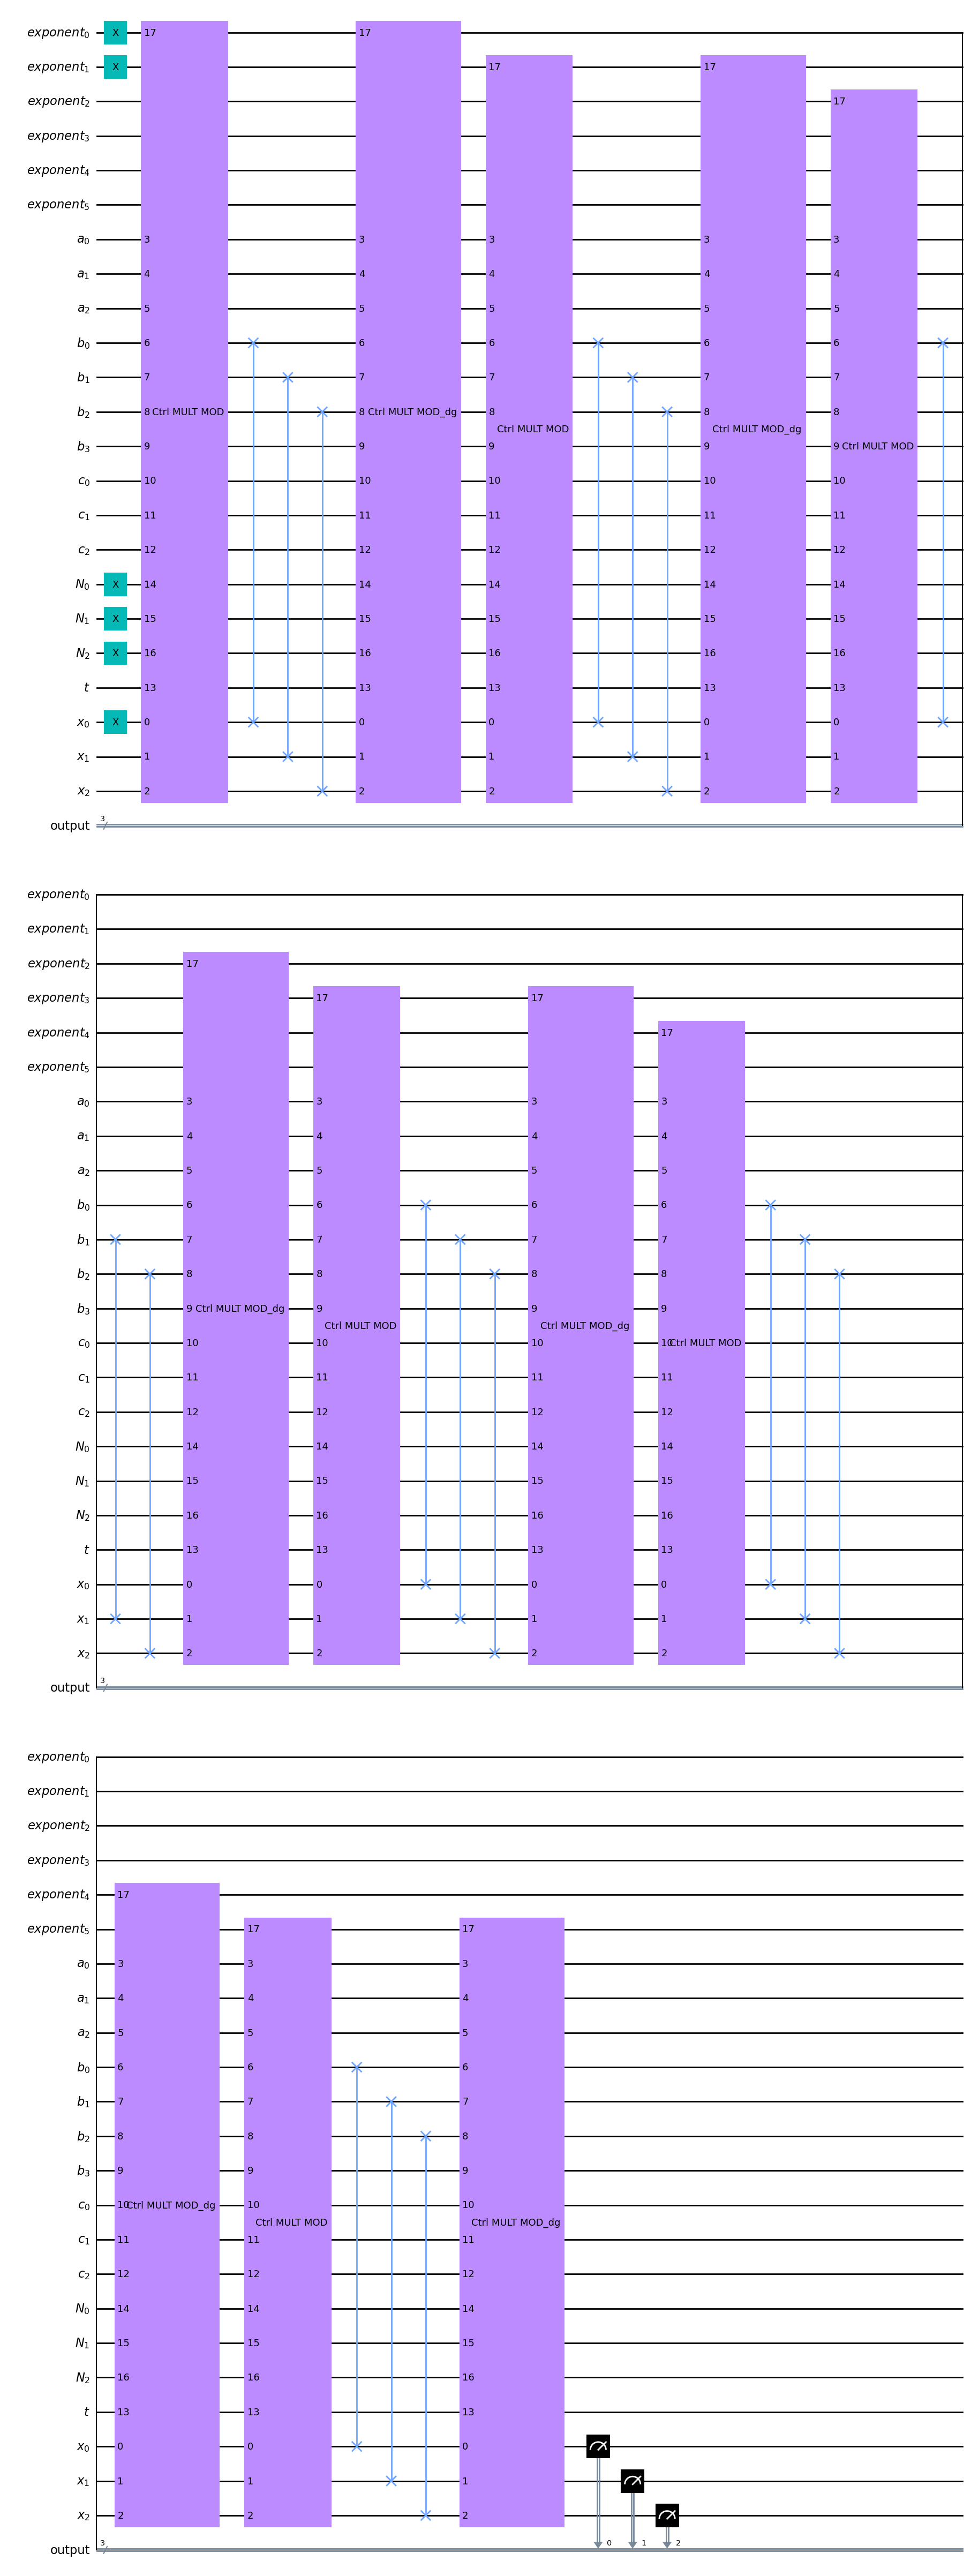

In [ ]:
circuit = mod_exp(3, 3, 7)
circuit.draw("mpl")
    

In [ ]:
simulator = Aer.get_backend("qasm_simulator")
compiled_circuit = transpile(circuit, simulator)
job = simulator.run(compiled_circuit, shots=1)
result = job.result()
counts = result.get_counts(compiled_circuit)
plot_histogram(counts)

AttributeError: module 'qiskit.visualization.circuit' has no attribute 'name'